In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if os.getcwd().endswith('notebooks'):
  os.chdir('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from src.training import investigate_predictions, calculate_metrics, load_config, DATA_TIME_INTERVAL

In [3]:
model_name = '022-rnn_layer_3' # change
config = load_config(model_name)

model_results = []
for i in range(config['repetitions'] if 'repetitions' in config else 1):
  with open(f'./models/{model_name}_{i+1}_meta.json') as f:
    model_results.append(json.load(f))

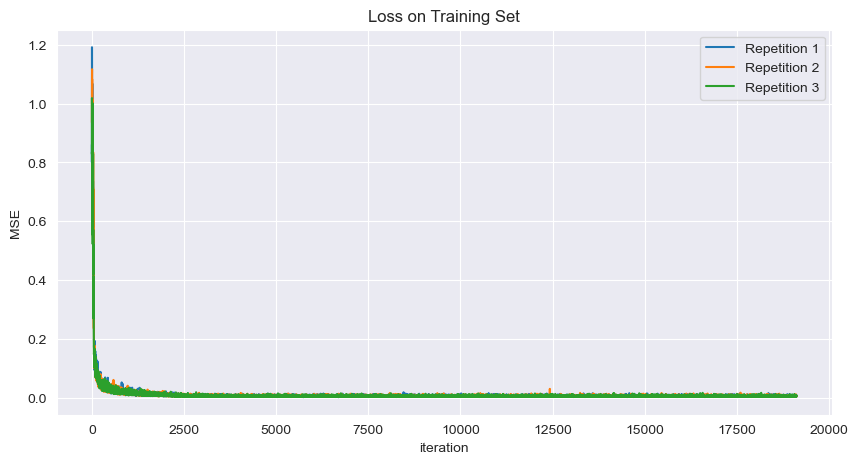

In [4]:
plt.figure(figsize=(10, 5))

for i, result in enumerate(model_results):
  sns.lineplot(result['loss'], label=f'Repetition {i + 1}')

plt.title('Loss on Training Set')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()

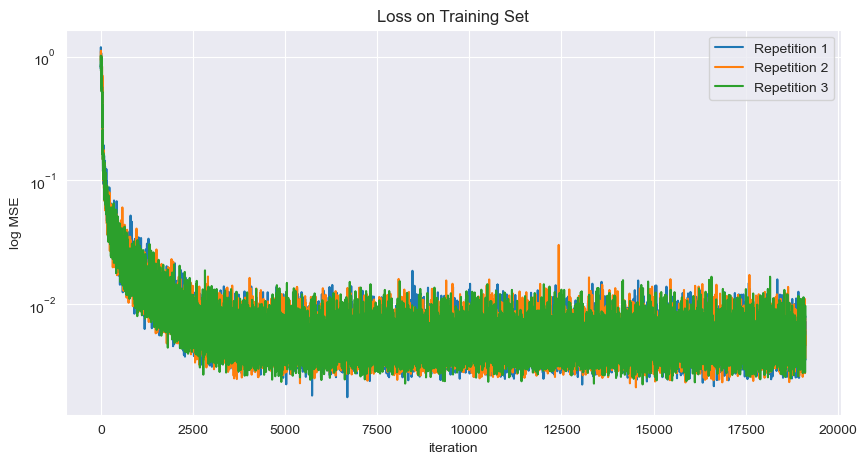

In [5]:
plt.figure(figsize=(10, 5))

for i, result in enumerate(model_results):
  sns.lineplot(result['loss'], label=f'Repetition {i + 1}')

plt.title('Loss on Training Set')
plt.xlabel('iteration')
plt.ylabel('log MSE')
plt.yscale('log')
plt.show()

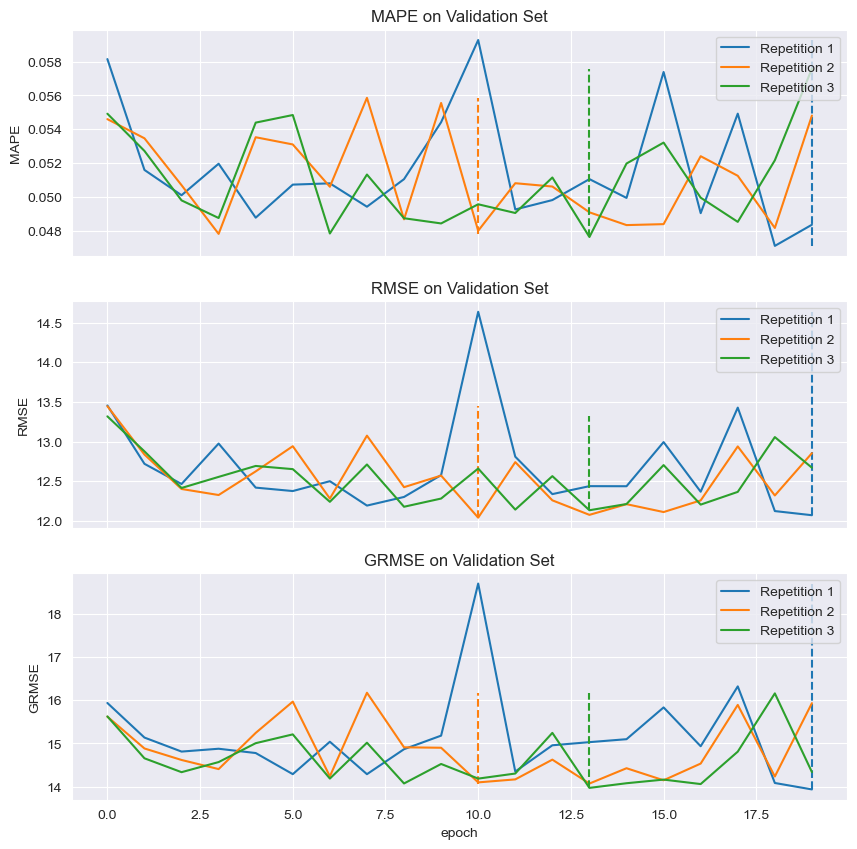

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for j, metric in enumerate(['mape', 'rmse', 'grmse']):
  for i, result in enumerate(model_results):
    sns.lineplot(result['val_scores'][metric], label=f'Repetition {i + 1}', ax=axs[j])
    axs[j].vlines(result['best_epoch'], np.min(result['val_scores'][metric]), np.max(result['val_scores'][metric]), axs[j].lines[-1].get_color(), '--')

  axs[j].set_title(metric.upper() + ' on Validation Set')
  axs[j].set_xlabel('epoch')
  axs[j].set_ylabel(metric.upper())

plt.show()

In [7]:
results = []
for i, result in enumerate(model_results):
  results.append({
    'best_epoch': result['best_epoch'],
    **{metric: scores[result['best_epoch']] for metric, scores in result['val_scores'].items()}
  })

results = pd.DataFrame(results)
mean = results.mean()
std = results.std()
results.loc['mean'] = mean
results.loc['std'] = std
results

,best_epoch,mse,rmse,mape,mae,gmse,grmse
0,19.000000,145.744354,12.072463,0.048373,7.185792,194.133881,13.933193
1,10.000000,144.999863,12.041589,0.048017,7.189260,198.709625,14.096440
2,13.000000,147.258118,12.134995,0.047648,7.201302,195.132187,13.968972
mean,14.000000,146.000778,12.083016,0.048013,7.192118,195.991898,13.999535
std,4.582576,1.150758,0.047589,0.000362,0.008140,2.405969,0.085808


In [19]:
X, y_preds, y_trues = investigate_predictions(model_name)

👉 loading model 1/3
👉 loading data
     training samples: 122261
     val samples: 30541
👉 predicting values


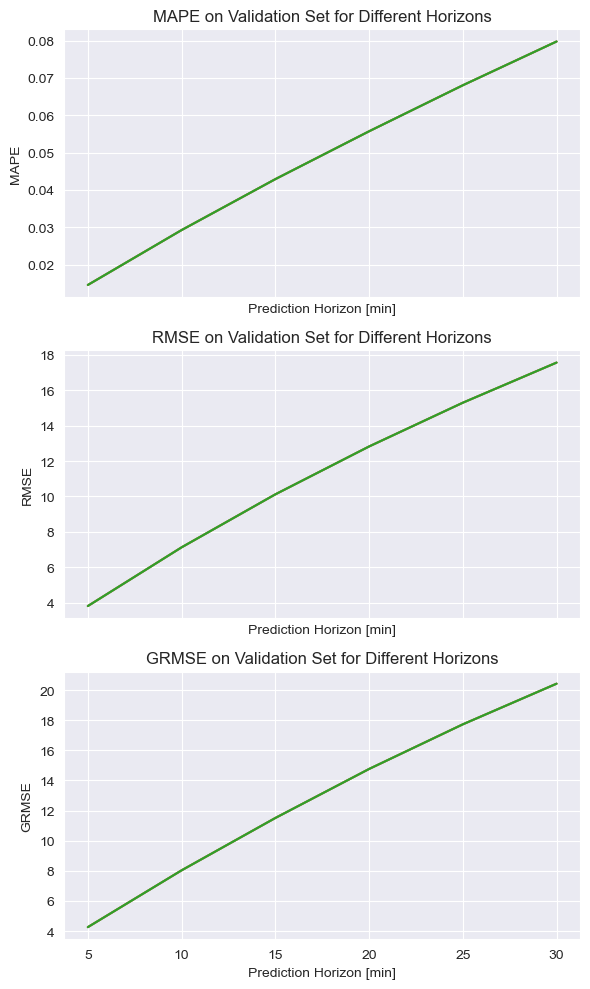

In [20]:
metric = 'rmse'

config = load_config(model_name)
n_pred = int(config['horizons']['pred'] / DATA_TIME_INTERVAL)

fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
for j, metric in enumerate(['mape', 'rmse', 'grmse']):
  scores = []
  for i in range(n_pred):
    score = calculate_metrics(y_preds[:, i], y_trues[:, i])[metric]
    scores.append(score)
  for i, result in enumerate(model_results):
    axs[j].plot(range(n_pred), scores)

  axs[j].set_title(metric.upper() + ' on Validation Set for Different Horizons')
  axs[j].set_xlabel('Prediction Horizon [min]')
  axs[j].set_xticks(range(n_pred), np.arange(0, config['horizons']['pred'], DATA_TIME_INTERVAL) + 5)
  axs[j].set_ylabel(metric.upper())

plt.tight_layout()
plt.show()

### Qualitative Analysis

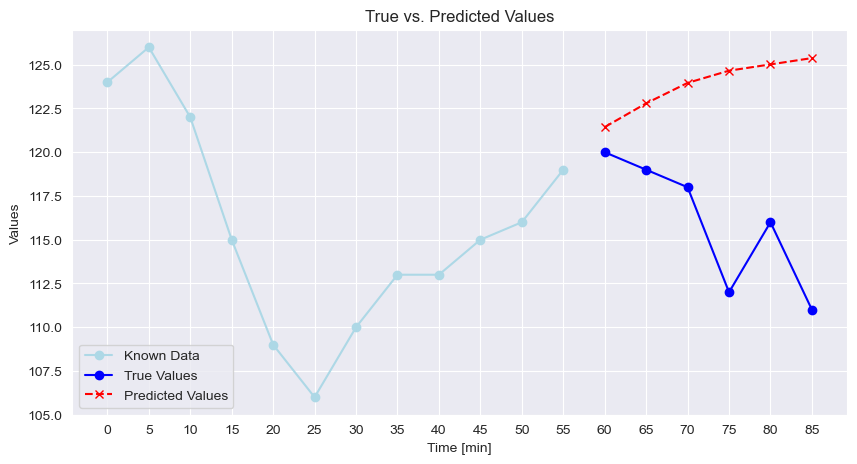

In [33]:
idx = 2006 # change

plt.figure(figsize=(10, 5))

# Line plot
plt.plot(np.arange(X.shape[1]), X[idx, :, 0], label='Known Data', color='lightblue', linestyle='-', marker='o')
plt.plot(np.arange(X.shape[1], X.shape[1] + y_trues.shape[1]), y_trues[idx].cpu(), label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(np.arange(X.shape[1], X.shape[1] + y_preds.shape[1]), y_preds[idx].cpu(), label='Predicted Values', color='red', linestyle='--', marker='x')

# Labels and title
plt.xlabel('Time [min]')
plt.xticks(np.arange(X.shape[1] + y_preds.shape[1]), np.arange(X.shape[1] + y_preds.shape[1]) * 5)
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

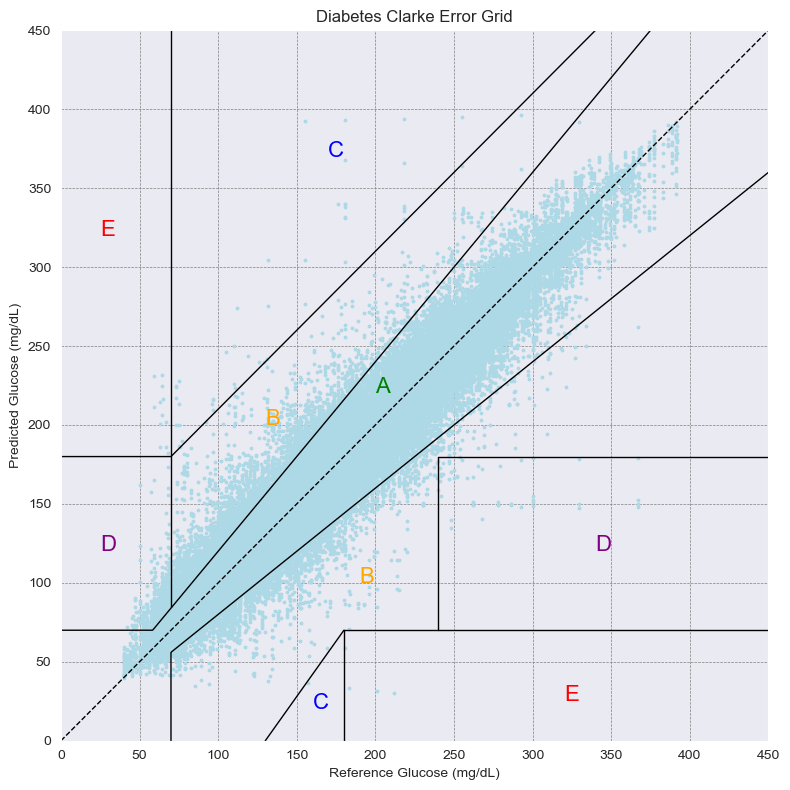

In [34]:
# Set up the plot
plt.figure(figsize=(8, 8))
plt.scatter(y_trues.flatten().cpu(), y_preds.flatten().cpu(), c='lightblue', s=3)
plt.title("Diabetes Clarke Error Grid")
plt.xlabel("Reference Glucose (mg/dL)")
plt.ylabel("Predicted Glucose (mg/dL)")
plt.xlim(0, 450)
plt.ylim(0, 450)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Diagonal lines
x = np.linspace(0, 450, 1000)
plt.plot(x, x, color='black', linestyle='--', linewidth=1)  # Line of identity
plt.plot(x, np.maximum(x * 1.2, 70), color='black', linestyle='-', linewidth=1) # Zone A/B Boundary (120%)
plt.plot(np.maximum(x, 70), x * 0.8, color='black', linestyle='-', linewidth=1) # Lower Zone A/B Boundary (80%)
plt.plot(np.linspace(130, 180, 1000), np.linspace(0, 70, 1000), color='black', linestyle='-', linewidth=1)
plt.plot(np.linspace(70, 70, 1000), np.linspace(85, 450, 1000), color='black', linestyle='-', linewidth=1)
plt.plot(x, np.maximum(x + 180 - 70, 180), color='black', linestyle='-', linewidth=1)
plt.plot(np.linspace(180, 450, 1000), np.linspace(70, 70, 1000), color='black', linestyle='-', linewidth=1)
plt.plot(np.linspace(180, 180, 1000), np.linspace(0, 70, 1000), color='black', linestyle='-', linewidth=1)
plt.plot(np.linspace(240, 240, 1000), np.linspace(70, 180, 1000), color='black', linestyle='-', linewidth=1)
plt.plot(np.linspace(240, 450, 1000), np.linspace(180, 180, 1000), color='black', linestyle='-', linewidth=1)

# Add labels for zones
plt.text(200, 220, "A", color="green", fontsize=16)
plt.text(130, 200, "B", color="orange", fontsize=16)
plt.text(190, 100, "B", color="orange", fontsize=16)
plt.text(160, 20, "C", color="blue", fontsize=16)
plt.text(170, 370, "C", color="blue", fontsize=16)
plt.text(340, 120, "D", color="purple", fontsize=16)
plt.text(25, 120, "D", color="purple", fontsize=16)
plt.text(320, 25, "E", color="red", fontsize=16)
plt.text(25, 320, "E", color="red", fontsize=16)

plt.tight_layout()
plt.show()

### Model Comparison

In [23]:
model_names = ['000-baseline'] # change

model_results = []
for model_name in model_names:
  config = load_config(model_name)

  for i in range(config['repetitions'] if 'repetitions' in config else 1):
    with open(f'./models/{model_name}_{i+1}_meta.json') as f:
      data = json.load(f)
      model_results.append({
        'model_name': model_name,
        **{metric: scores[data['best_epoch']] for metric, scores in data['val_scores'].items()}
      })

model_results = pd.DataFrame(model_results)

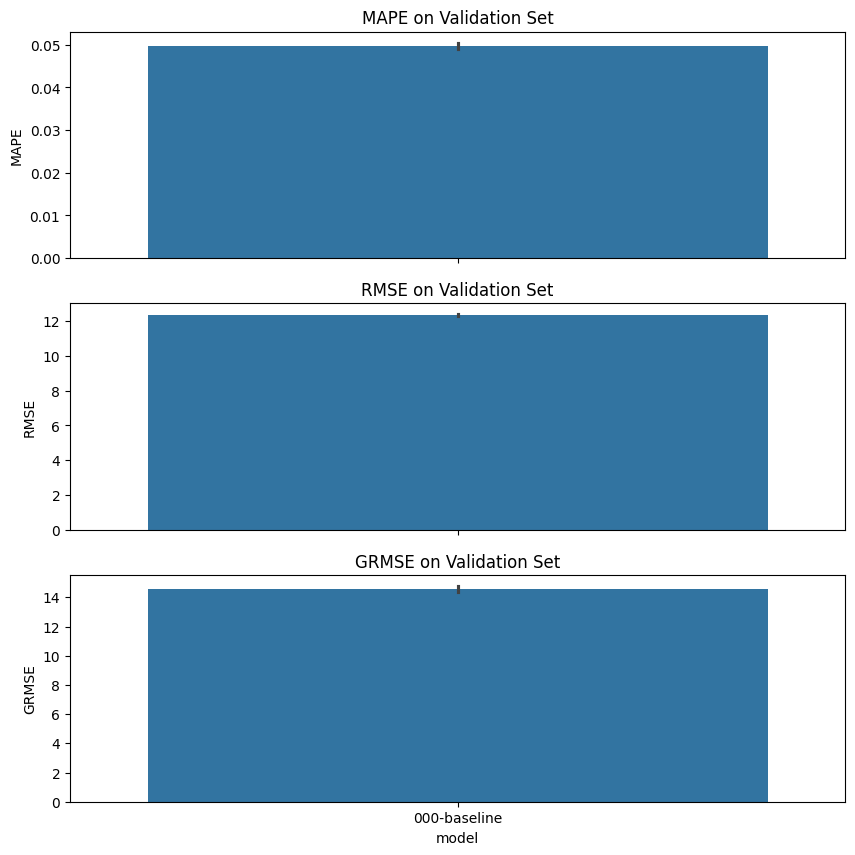

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
for j, metric in enumerate(['mape', 'rmse', 'grmse']):
  sns.barplot(model_results, x='model_name', y=metric, errorbar='sd', ax=axs[j])

  axs[j].set_title(metric.upper() + ' on Validation Set')
  axs[j].set_xlabel('model')
  axs[j].set_ylabel(metric.upper())

plt.show()

In [14]:
means = model_results.groupby('model_name').mean().round(2)
stds = model_results.groupby('model_name').std().round(2)

table = means.astype(str).add(' ± ').add(stds.astype(str))
table.columns = table.columns.str.upper()
table = table.rename(columns={'GMSE': 'gMSE', 'GRMSE': 'gRMSE'})
table = table[['RMSE', 'MAPE', 'gRMSE']]
table.index.name = None
table

,RMSE,MAPE,gRMSE
000-baseline,12.33 ± 0.05,0.05 ± 0.0,14.56 ± 0.22


In [15]:
table.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n & RMSE & MAPE & gRMSE \\\\\n\\midrule\n000-baseline & 12.33 ± 0.05 & 0.05 ± 0.0 & 14.56 ± 0.22 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Old Stuff

Numerical metrics

In [123]:
# Extract relevant metrics
best_epoch = model_data['best_epoch']
training_losses = model_data['loss']
val_scores = model_data['val_scores']

# Get MAPE and loss at the best epoch
best_mape = val_scores['mape'][best_epoch]
best_loss = training_losses[best_epoch]

# Print metrics for comparison
print(f"Model: {model_name}")
print(f"Best Epoch: {best_epoch}")
print(f"Training Loss at Best Epoch: {best_loss:.4f}")
print(f"Validation MAPE at Best Epoch: {best_mape:.4f}")

Model: 022-3-layers
Best Epoch: 13
Training Loss at Best Epoch: 0.7685
Validation MAPE at Best Epoch: 0.0489


Aggregate Metrics for Comparison

In [23]:
mean_mape = np.mean(val_scores['mape'])
std_mape = np.std(val_scores['mape'])

print(f"Mean Validation MAPE: {mean_mape:.4f}")
print(f"Standard Deviation of Validation MAPE: {std_mape:.4f}")

Mean Validation MAPE: 0.0626
Standard Deviation of Validation MAPE: 0.0106


Worst-case Performance

In [24]:
max_mape = np.max(val_scores['mape'])
print(f"Worst-case Validation MAPE: {max_mape:.4f}")

Worst-case Validation MAPE: 0.0905


Comparison Table

In [25]:
models_metrics = [
  {"model": "001-rnn", "best_epoch": best_epoch, "best_loss": best_loss, "best_mape": best_mape},
  # Add data for other models here
]

# Display as a pandas DataFrame
df_metrics = pd.DataFrame(models_metrics)
print(df_metrics)


     model  best_epoch  best_loss  best_mape
0  001-rnn           5   0.355615   0.056595


# Using Functions in scr.evaluation.py

In [1]:
import os
if os.getcwd().endswith('notebooks'):
  os.chdir('..')

from src.evaluation import model_evaluation_plots, model_evaluation_numeric, model_comparison_table

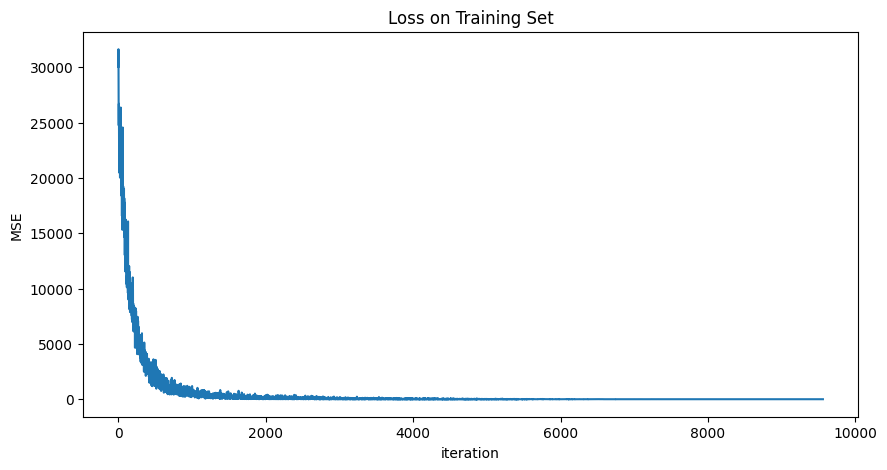

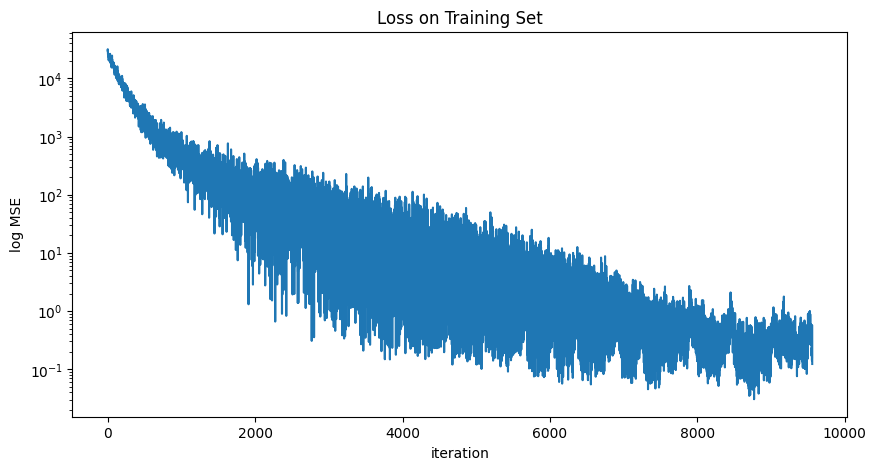

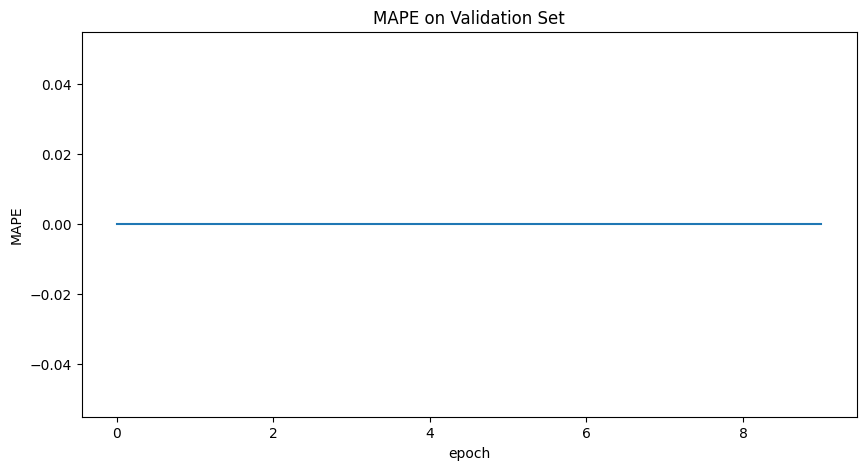

In [3]:
model_evaluation_plots("007-rnn-larger")

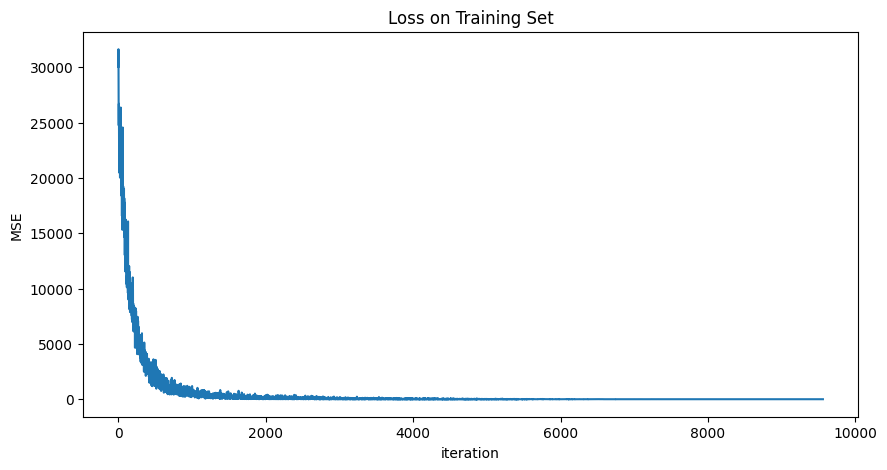

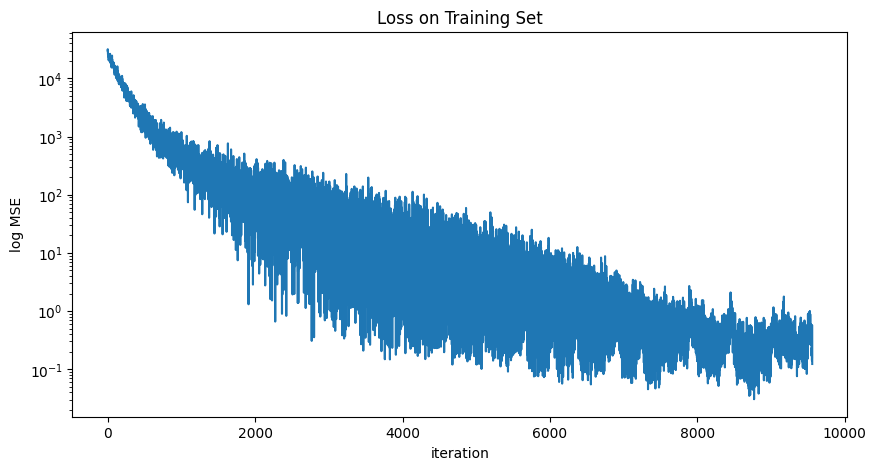

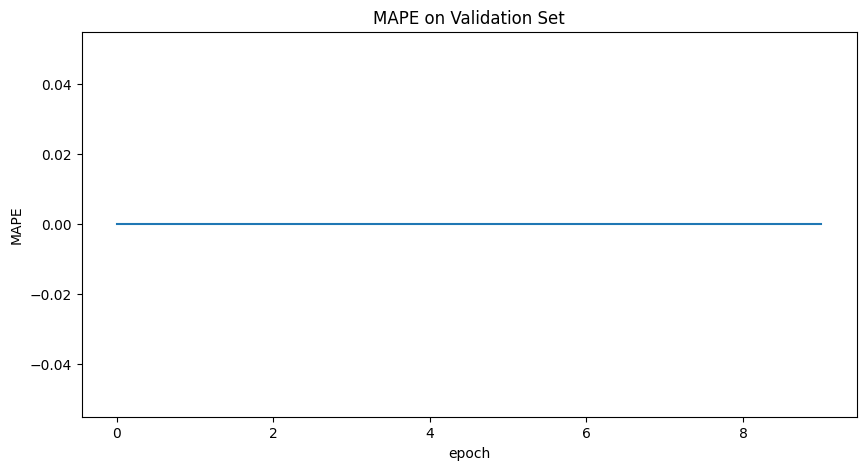

In [4]:
model_evaluation_plots('002-rnn')

In [5]:
model_evaluation_numeric('007-rnn-larger')

Model: 007-rnn-larger
Best Epoch: 0
Training Loss at Best Epoch: 30040.1191
Validation MAPE at Best Epoch: 0.0000
Mean Validation MAPE: 0.0000
Standard Deviation of Validation MAPE: 0.0000
Worst-case Validation MAPE: 0.0000


(0, 30040.119140625, 0.0)

In [2]:
model_comparison_table(['001-rnn', '002-rnn', '007-rnn-larger'])

Model: 001-rnn
Best Epoch: 9
Training Loss at Best Epoch: 30140.2949
Validation MAPE at Best Epoch: 0.0575
Mean Validation MAPE: 0.1698
Standard Deviation of Validation MAPE: 0.1681
Worst-case Validation MAPE: 0.6030
Model: 002-rnn
Best Epoch: 0
Training Loss at Best Epoch: 28294.6621
Validation MAPE at Best Epoch: 0.0000
Mean Validation MAPE: 0.0000
Standard Deviation of Validation MAPE: 0.0000
Worst-case Validation MAPE: 0.0000
Model: 007-rnn-larger
Best Epoch: 0
Training Loss at Best Epoch: 30040.1191
Validation MAPE at Best Epoch: 0.0000
Mean Validation MAPE: 0.0000
Standard Deviation of Validation MAPE: 0.0000
Worst-case Validation MAPE: 0.0000
            model  best_epoch     best_loss  best_mape
0         001-rnn           9  30140.294922   0.057468
1         002-rnn           0  28294.662109   0.000000
2  007-rnn-larger           0  30040.119141   0.000000


,model,best_epoch,best_loss,best_mape
0,001-rnn,9,30140.294922,0.057468
1,002-rnn,0,28294.662109,0.000000
2,007-rnn-larger,0,30040.119141,0.000000
